In [23]:
from typing import Dict
import torch
from src import datasets_loader
from src.utils import retrieval_eval, pool_and_normalize
from src.constants import GFG_DATA_PATH
from transformers import AutoModel, AutoTokenizer
from src.datasets_loader import prepare_tokenizer
from src.preprocessing_utils import truncate_sentences
from abc import ABC, abstractmethod
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np


In [2]:
DEVICE = "cuda:0"

EVAL_CONFIGS =[
    {"model_path": "starencoder", "maximum_raw_length": 10000, "maximum_input_length": 1024, "device": DEVICE},
    {"model_path": "codebert", "maximum_raw_length": 10000, "maximum_input_length": 512, "device": DEVICE}
]

In [12]:
def set_device(inputs: Dict[str, torch.Tensor], device: str) -> Dict[str, torch.Tensor]:
    output_data = {}
    for k, v in inputs.items():
        output_data[k] = v.to(device)

    return output_data


def get_dataset(maximum_raw_length):
    test_data = datasets_loader.get_dataset(  # Geeks4Geeks data
        dataset_name="gfg",
        path_to_cache=GFG_DATA_PATH,
        split="test",
        maximum_raw_length=maximum_raw_length,
    )

    return test_data


class BaseEncoder(torch.nn.Module, ABC):
    def __init__(self, device, max_input_len, maximum_token_len, model_name):
        super().__init__()

        self.model_name = model_name
        self.tokenizer = prepare_tokenizer(model_name)
        self.encoder = (
            AutoModel.from_pretrained(model_name, use_auth_token=True).to(DEVICE).eval()
        )
        self.device = device
        self.max_input_len = max_input_len
        self.maximum_token_len = maximum_token_len

    @abstractmethod
    def forward(
        self,
    ):
        pass

    def encode(self, input_sentences, batch_size=32, **kwargs):
        truncated_input_sentences = truncate_sentences(
            input_sentences, self.max_input_len
        )

        n_batches = len(truncated_input_sentences) // batch_size + int(
            len(truncated_input_sentences) % batch_size > 0
        )

        embedding_batch_list = []

        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(truncated_input_sentences))

            with torch.no_grad():
                embedding_batch_list.append(
                    self.forward(truncated_input_sentences[start_idx:end_idx])
                    .detach()
                    .cpu()
                )

        return torch.cat(embedding_batch_list)


class StarEncoder(BaseEncoder):
    def __init__(self, device, max_input_len, maximum_token_len):
        super().__init__(
            device,
            max_input_len,
            maximum_token_len,
            model_name="bigcode/starencoder",
        )

    def forward(self, input_sentences):
        inputs = self.tokenizer(
            [
                f"{self.tokenizer.cls_token}{sentence}{self.tokenizer.sep_token}"
                for sentence in input_sentences
            ],
            padding="longest",
            max_length=self.maximum_token_len,
            truncation=True,
            return_tensors="pt",
        )

        outputs = self.encoder(**set_device(inputs, self.device))
        embedding = pool_and_normalize(outputs.hidden_states[-1], inputs.attention_mask)

        return embedding


class CodeBERT(BaseEncoder):
    def __init__(self, device, max_input_len, maximum_token_len):
        super().__init__(
            device,
            max_input_len,
            maximum_token_len,
            model_name="microsoft/codebert-base",
        )

        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

    def forward(self, input_sentences):
        inputs = self.tokenizer(
            [sentence for sentence in input_sentences],
            padding="longest",
            max_length=self.maximum_token_len,
            truncation=True,
            return_tensors="pt",
        )

        inputs = set_device(inputs, self.device)

        outputs = self.encoder(inputs["input_ids"], inputs["attention_mask"])

        embedding = outputs["pooler_output"]

        return torch.cat([torch.nn.functional.normalize(torch.Tensor(el)[None, :]) for el in embedding])


def evaluate(model_path, maximum_raw_length, maximum_input_length, device):
    if "starencoder" in model_path.lower():
        model = StarEncoder(
            device, maximum_raw_length, maximum_input_length
        )
    elif "codebert" in model_path.lower():
        model = CodeBERT(
            device, maximum_raw_length, maximum_input_length
        )
    else:
        raise ValueError(
            "Unsupported model type. We currently support starencoder and codebert."
        )

    model = model.to(device)
    model.eval()

    test_data = get_dataset(maximum_raw_length)

    source_entries, target_entries = [], []
    for source, target in test_data:
        source_entries.append(source)
        target_entries.append(target)

    source_embeddings = model.encode(source_entries)
    target_embeddings = model.encode(target_entries)

    recall_at_1, recall_at_5, mean_reciprocal_rank, similarities = retrieval_eval(
        source_embeddings, target_embeddings, return_similarities=True
    )

    print(
        f"\n{model_path}: R@1: {recall_at_1.item()}, R@5: {recall_at_5.item()}, MRR: {mean_reciprocal_rank.item()}"
        )
    
    return similarities

In [13]:
model_to_similarities = {}

with torch.no_grad():
    for eval_cfg in EVAL_CONFIGS:
        similarities = evaluate(**eval_cfg)
        model_to_similarities[eval_cfg["model_path"]] = similarities.ravel().detach().cpu().numpy()

Some weights of the model checkpoint at bigcode/starencoder were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached shuffled indices for dataset at /mnt/home/bigcode-encoder/resources/data/transcoder_evaluation_gfg/cache-e


starencoder: R@1: 0.7222222089767456, R@5: 0.8784722089767456, MRR: 0.7927579879760742


Loading cached shuffled indices for dataset at /mnt/home/bigcode-encoder/resources/data/transcoder_evaluation_gfg/cache-e9f62aa12abed28d.arrow
Loading cached processed dataset at /mnt/home/bigcode-encoder/resources/data/transcoder_evaluation_gfg/cache-62c8dbaa90db85ee_*_of_00096.arrow
Loading cached shuffled indices for dataset at /mnt/home/bigcode-encoder/resources/data/transcoder_evaluation_gfg/cache-f652c1e33d8c1a14.arrow



codebert: R@1: 0.2725694477558136, R@5: 0.4826388955116272, MRR: 0.3659176826477051


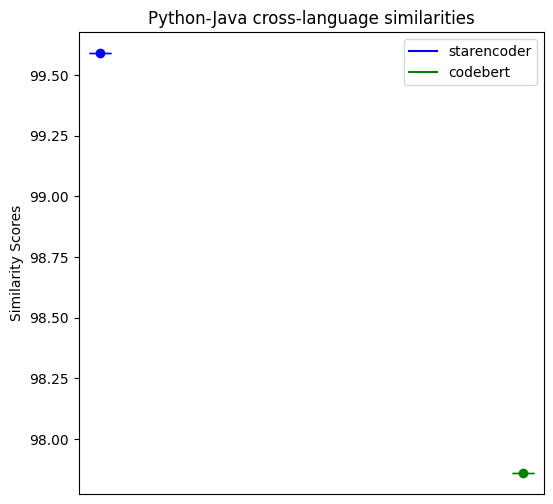

In [26]:
def summarize_sequence(sequence):
    def ci95(seq):
        return 1.96 * np.std(seq) / np.sqrt(len(seq))

    return f"{100*np.mean(sequence):.2f}+-{100*ci95(sequence):.2f}"

fig, ax = plt.subplots(figsize=(6,6), facecolor="white")

ax.set_title("Python-Java cross-language similarities")
ax.get_xaxis().set_visible(False)
ax.set_ylabel("Similarity Scores")

color_list = [k for k in mcolors.BASE_COLORS.keys()]

for i, (k, v) in enumerate(model_to_similarities.items()):

    score_ci = summarize_sequence(v)
    center, error = score_ci.split("+-")

    try:
        color = color_list[i]
    except IndexError:
        break

    plt.plot(i+1, float(center), color=color, label=k)
    plt.errorbar(i+1, float(center), yerr=float(error), fmt ='-o', color=color, capsize=8)


plt.legend(loc="upper right")
plt.show()
        